# Visualization ConvNet Filters by Activation Maximization

In [1]:
import torch
from torch import nn
import timm
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

e:\Rijan_Shrestha\AI\AI Works\Paper-Reproduction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Filter visualization using Gradient Ascent

### Plan:
1. Initialize the pretrained model - Xception using timm (not available in torchvision)
2. To extract the output of the certain layer, create the hook and register it for forward pass
3. Initialize the empty tensor of shape 1, 224, 224 for creating blank image
4. With the layer as the features extractor, forward pass the blank image and take the score of that as the loss we need
5. Backward pass on the loss
6. Keeping the weights and bias constant, take the optimizer to update the value of the pixel for maximal activation
7. Visualize the generated image

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
model = timm.create_model('xception', pretrained = True, global_pool = '', num_classes = 0)
model = model.to(device)
summary(model, (3, 180, 180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 89, 89]             864
       BatchNorm2d-2           [-1, 32, 89, 89]              64
              ReLU-3           [-1, 32, 89, 89]               0
            Conv2d-4           [-1, 64, 87, 87]          18,432
       BatchNorm2d-5           [-1, 64, 87, 87]             128
              ReLU-6           [-1, 64, 87, 87]               0
            Conv2d-7           [-1, 64, 87, 87]             576
            Conv2d-8          [-1, 128, 87, 87]           8,192
   SeparableConv2d-9          [-1, 128, 87, 87]               0
      BatchNorm2d-10          [-1, 128, 87, 87]             256
             ReLU-11          [-1, 128, 87, 87]               0
           Conv2d-12          [-1, 128, 87, 87]           1,152
           Conv2d-13          [-1, 128, 87, 87]          16,384
  SeparableConv2d-14          [-1, 128,

In [52]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

layer_name = "block1.rep.3.conv1"
layer = dict(model.named_modules())[layer_name]

# Register the hook
handle = layer.register_forward_hook(get_activation(layer_name))

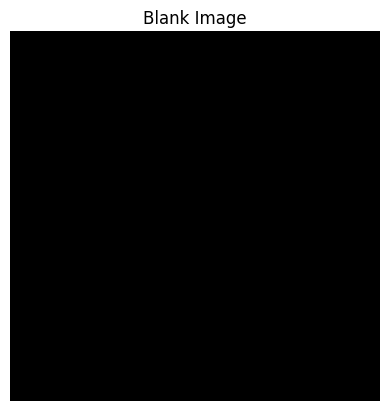

In [53]:
#Crete the blank image
blank_image = torch.zeros(1 , 3, 180, 180, device = device, requires_grad= True)

plt.imshow(blank_image.detach().cpu().permute(0, 2, 3, 1).squeeze(0))
plt.title("Blank Image")
plt.axis('off')
plt.show()

In [71]:
#Forward pass
def feature_extractor(x):
    model(x)
    return activation['block1.rep.3.conv1']

In [ ]:
activation['block1.rep.3.conv1'].shape

torch.Size([1, 128, 87, 87])

In [75]:
def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    feature = activation[:, filter_index, 2:-2, 2:-2]
    return torch.mean(feature)

compute_loss(blank_image, 3)

tensor(-0.2252, device='cuda:0')

In [76]:
def gradient_ascent_step(image, filter_index, learning_rate = 10.0):
    image = image.clone().detach().requires_grad_(True)

    loss = compute_loss(image, filter_index)
    loss.backward()

    grads = image.grad
    grads_norm = torch.norm(grads, p = 2) + 1e-8
    normalized_grads = grads / grads_norm
    image += learning_rate * normalized_grads

    return image.detach()
    

In [79]:
def generate_filter_pattern(filter_index, img_size = 299, iterations = 30, lr = 10.0):
    image = torch.randn(1, 3, img_size, img_size) * 0.2 - 0.1
    image = image.requires_grad_(True)

    for i in range(iterations):
        image = gradient_ascent_step(image, 10, lr)

    return image.detach()

In [80]:
def deprocess_image(img_tensor):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()

    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1

    img+= 0.5
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    return img